Author: Darian Hadjiabadi
This is still a quantitative analysis but since checking for overfitting is important I made it its own notebook.
Uses Kernel MMD to ensure that generated images between training and validations set exhibit little gap. High gap would indicate
overfitting.

In [2]:
import numpy as np
import sys
import os

import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

from gan.network_utils import run_a_gan
from gan.network_utils import show_images
from gan.network_utils import initialize_weights
from gan.network_utils import gan_generate
from gan.network_utils import count_params
from gan.network_utils import save_model
from gan.network_utils import load_model
from gan.network import discriminator
from gan.network import dc_discriminator
from gan.network import vanilla_discriminator_loss
from gan.network import ls_discriminator_loss
from gan.network import generator
from gan.network import dc_generator
from gan.network import vanilla_generator_loss
from gan.network import ls_generator_loss
from scipy import misc
import glob
from gan.network import get_optimizer


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

%load_ext autoreload
%autoreload 2





In [4]:
def read_imgs(dir_fn, img_size=64):
    imgs = np.zeros((10000,img_size,img_size))
    count = 0
    for image_path in glob.glob(dir_fn + '*.png'):
        image = misc.imread(image_path)
        imgs[count, :, :] = image
        count += 1
    return imgs[0:count,:,:]

def dg_gan_run(dtype, lrd, lrg, beta1, beta2, num_epochs=25, show=True, return_model=False, batch_size=64, label_smoothing=False, instance_noise=False, validation=False, validation_set=None, train_set=None):

    D_DC = dc_discriminator(batch_size).type(dtype) 
    D_DC.apply(initialize_weights)
    G_DC = dc_generator(batch_size).type(dtype)
    G_DC.apply(initialize_weights)

    D_DC_solver = get_optimizer(D_DC, lr=lrd, beta1=beta1, beta2=beta2)
    G_DC_solver = get_optimizer(G_DC, lr=lrg, beta1=beta1, beta2=beta2)
    if validation:
        return run_a_gan(loader_train, dtype, D_DC, G_DC, D_DC_solver, G_DC_solver, vanilla_discriminator_loss, 
                                                          vanilla_generator_loss,num_epochs=num_epochs, show=show, label_smoothing=label_smoothing, 
                                                          instance_noise=instance_noise, validation=validation, validation_set=validation_set, train_set=train_set)
    else:
        d_loss_list, g_loss_list, fake_imgs, D, G = run_a_gan(loader_train, dtype, D_DC, G_DC, D_DC_solver, G_DC_solver, vanilla_discriminator_loss, 
                                                          vanilla_generator_loss,num_epochs=num_epochs, show=show, label_smoothing=label_smoothing, 
                                                          instance_noise=instance_noise, validation=validation, validation_set=validation_set, train_set=train_set)
    if return_model:
        return d_loss_list, g_loss_list, fake_imgs, D, G
    else:
        return d_loss_list, g_loss_list, fake_imgs


class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

    
    

In [3]:
batch_size = 64
NUM_TRAIN = 2500
dtype = torch.cuda.FloatTensor
cell_type = 'granule'
neuron_train = dset.ImageFolder('./database-imgs-full/' + cell_type + '/train/', transform=T.ToTensor())
loader_train = DataLoader(neuron_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

validation_set = read_imgs('database-imgs-full/granule/test/a/')
val_num = validation_set.shape[0]
train_set = read_imgs('database-imgs-full/granule/train/a/')
train_set = train_set[0:val_num,:,:]

validation_set /= 255
train_set /= 255

print('loaded')

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


loaded


In [4]:
lr_granule = 0.00059510829414641
gap_list_good, D_good, G_good = dg_gan_run(dtype, lr_granule, lr_granule, 0.50, 0.999, num_epochs=100, 
                                                       show=False, return_model=True, label_smoothing=1, instance_noise=1, validation=True, validation_set=validation_set, train_set=train_set)
print('done')

gap_list_bad, D_bad, G_bad = dg_gan_run(dtype, lr_granule, lr_granule, 0.50, 0.999, num_epochs=100, 
                                                       show=False, return_model=True, label_smoothing=0, instance_noise=0, validation=True, validation_set=validation_set, train_set=train_set)

print('done')

0.24954504892997742 0.2502512348327566 0.0
0.4367793606716432 0.43821242028127483 0.0
0.2558944786985805 0.2552234745355346 0.0
0.22759444836054415 0.22777797436974498 0.0
0.22797974816815536 0.22816598808054037 0.0
0.2797288764576932 0.27740190429434763 0.0
0.2697354718530882 0.2711041282768845 0.0
0.23584188845043372 0.22944690196003303 0.0
0.22231149212572499 0.22209398239898398 0.0
0.2287540414067164 0.22859841731336458 0.0
0.20116522466965084 0.19652002460034082 0.0
0.21531346389409473 0.21331987940194763 0.0
0.16188340132216913 0.16255372599798645 0.0
0.1636393190262096 0.1624594789520165 0.0
0.17351672490205225 0.17066282324992263 0.0
0.16848449699087537 0.16777296346007797 0.0
0.15802637072892203 0.15309590671751053 0.0
0.11900585991379352 0.11792859366139591 0.0
0.14772770875431504 0.14886045389947544 0.0
0.13130480356729296 0.12955605938090836 0.0
0.1295988369838408 0.12787509958401874 0.0
0.13339206999401493 0.13411253571423476 0.0
0.12983082023333786 0.12889034473622618 0.0

0.06731171607336757 0.06950203960820023 0.0
0.06254497334817526 0.05919265511949412 0.0
0.06663561557710491 0.06690480957415988 0.0
0.07032422270766778 0.06397388562167984 0.0
0.06102668434814692 0.05978634424550396 0.0
0.06573275841733053 0.07152557528290981 0.0
0.06764888878720193 0.06743281382547518 0.0
0.07362556278274822 0.06759686987439756 0.0
0.07128544882317055 0.0726887833375902 0.0
0.0708918046304594 0.0642883827749985 0.0
done


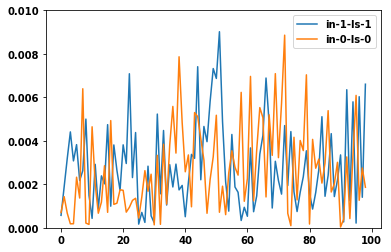

In [11]:
t = np.arange(len(gap_list_bad))
plt.plot(t, gap_list_bad)
plt.plot(t, gap_list_good)
plt.ylim((0.0,0.01))
plt.legend(['in-1-ls-1', 'in-0-ls-0'])
plt.show()


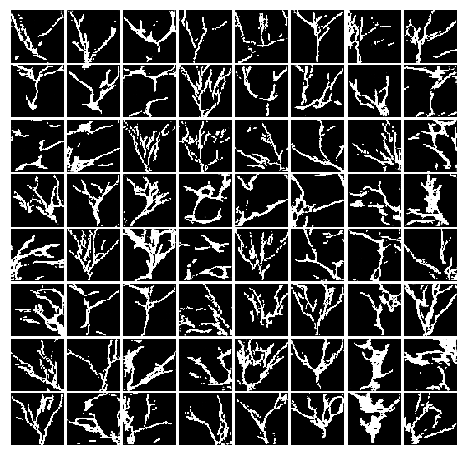

In [7]:
fake_imgs = gan_generate(dtype, G_good)
show_images(fake_imgs)

In [5]:
batch_size = 64
NUM_TRAIN = 4600
dtype = torch.cuda.FloatTensor
cell_type = 'pyramidal'
neuron_train = dset.ImageFolder('./database-imgs-full/' + cell_type + '/train/', transform=T.ToTensor())
loader_train = DataLoader(neuron_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

validation_set = read_imgs('database-imgs-full/granule/test/a/')
val_num = validation_set.shape[0]
train_set = read_imgs('database-imgs-full/granule/train/a/')
train_set = train_set[0:val_num,:,:]

validation_set /= 255
train_set /= 255

print('loaded')

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


loaded


In [6]:
lr_pyramidal = 0.0006852589613748453
pyrgap_list_good, pyrD_good, pyrG_good = dg_gan_run(dtype, lr_pyramidal, lr_pyramidal, 0.50, 0.999, num_epochs=100, 
                                                       show=False, return_model=True, label_smoothing=1, instance_noise=0, validation=True, validation_set=validation_set, train_set=train_set)
print('done')

pyrgap_list_bad, pyrD_bad, pyrG_bad = dg_gan_run(dtype, lr_pyramidal, lr_pyramidal, 0.50, 0.999, num_epochs=100, 
                                                       show=False, return_model=True, label_smoothing=0, instance_noise=0, validation=True, validation_set=validation_set, train_set=train_set)

print('done')

0.3224413978299667 0.32416964816651117 0.0
0.212372829961037 0.2112422497679049 0.0
0.18384858177734179 0.182328716316831 0.0
0.197650036487519 0.19401660493503725 0.0
0.16904682381121128 0.16743180587583056 0.0
0.21702829199426907 0.21256756043422373 0.0
0.20486104566959834 0.2063431333640068 0.0
0.18131424446480546 0.18016408924383903 0.0
0.16001784135503486 0.1559687938285806 0.0
0.16134945576531126 0.15842145599344218 0.0
0.16102313868567059 0.1587650165491739 0.0
0.16109736494016286 0.15754570930221964 0.0
0.17538774978846786 0.16974620787279537 0.0
0.14359677507033766 0.14406647525419825 0.0
0.12002625579021234 0.11806226568052797 0.0
0.14532100902519635 0.14086837682387998 0.0
0.1239651974541655 0.123184125020112 0.0
0.1297783533568676 0.12713353948575778 0.0
0.1461543661375554 0.14359766310720382 0.0
0.1334960591660182 0.13151192065059705 0.0
0.13113130707388887 0.13159684116069464 0.0
0.12478642097720107 0.12360828940451626 0.0
0.16673990789655188 0.1512062581964313 0.0
0.1382

0.12335962667573731 0.11955347970586264 0.0
0.12500009451922695 0.11975624446321452 0.0
0.11182357068737116 0.10825109238096939 0.0
0.11079162100155282 0.1098272322430035 0.0
0.1235650607170122 0.12082612461199391 0.0
0.10625678789486372 0.10102752821518325 0.0
0.10381443552759764 0.09571939205790334 0.0
0.11067987897965541 0.10577470413059077 0.0
0.11646712742895358 0.11623412194117155 0.0
0.11534774072293472 0.11291075271705368 0.0
done


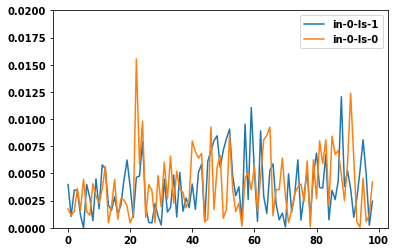

In [8]:
t = np.arange(len(pyrgap_list_bad))
plt.plot(t, pyrgap_list_bad)
plt.plot(t, pyrgap_list_good)
plt.ylim((0.0,0.02))
plt.legend(['in-0-ls-1', 'in-0-ls-0'])
plt.show()


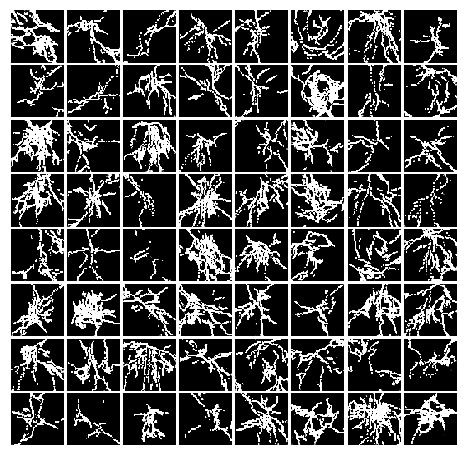

In [10]:
fake_imgs = gan_generate(dtype, pyrG_good)
show_images(fake_imgs)